### Бусько Полина, гр. 3824М1ПМвм

## Лабораторная работа №1: «Метод обратного распространения ошибки»

### Задачи работы
Выполнение лабораторной работы предполагает решение следующих задач:

1. Изучить общую схему работы метода обратного распространения ошибки с использованием стохастического градиентного спуска.
2. Вывести математические формулы для вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов.
3. Загрузить набор данных MNIST, выполнить предобработку изображений и меток, если это необходимо.
4. Реализовать и протестировать метод обратного распространения ошибки для задачи классификации рукописных цифр из набора данных MNIST.
___

### Конфигурация нейронной сети
1. Входной слой содержит `w x h` нейронов, что соответствует разрешению одноканального изображения. Для набора MNIST это составляет `28 x 28`.
2. Выходной слой содержит `k` нейронов, что соответствует количеству классов изображений. Для задачи классификации рукописных цифр MNIST — 10 классов.
3. Скрытый слой содержит `s` нейронов (параметр).
4. Параметры метода обучения:
    + Скорость обучения (learning rate)
    + Размер пачки данных (batch size)
    + Количество эпох
5. Функции активации:
    + На скрытом слое — функция ReLU.
    + На выходном слое — функция softmax.
    + Входной слой не содержит функции активации.
6. Функция ошибки — кросс-энтропия. softmax вместе с кросс-энтропией упрощает вывод формул.
7. Контрольные параметры для демонстрации работы нейронной сети:
    + Размер пачки данных: от 8 до 64 изображений (в зависимости от доступного объема памяти).
    + Скорость обучения: 0.1.
    + Количество скрытых нейронов `s`: 300.
    + Количество эпох: 20.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time

## Загрузка и проверка данных

In [2]:
def load_img(filename):
    with open(filename, 'rb') as f:
        f.read(16)  
        images = np.fromfile(f, dtype=np.uint8)
        images = images / 255.0
        images = images.reshape(-1, 28, 28)
    return images

def load_labels(filename):
    with open(filename, 'rb') as f:
        f.read(8)
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

In [3]:
train_img = load_img('mnist/train-images-idx3-ubyte')
train_labels = load_labels('mnist/train-labels-idx1-ubyte')
test_img = load_img('mnist/t10k-images-idx3-ubyte')
test_labels = load_labels('mnist/t10k-labels-idx1-ubyte')
print("Размеры тренировочных данных:")
print ("train_images: ", train_img.shape, ", train_labels: ", train_labels.shape)
print("Размеры тестовых данных:")
print("test_images: ", test_img.shape, ", test_labels: ", test_labels.shape)

Размеры тренировочных данных:
train_images:  (60000, 28, 28) , train_labels:  (60000,)
Размеры тестовых данных:
test_images:  (10000, 28, 28) , test_labels:  (10000,)


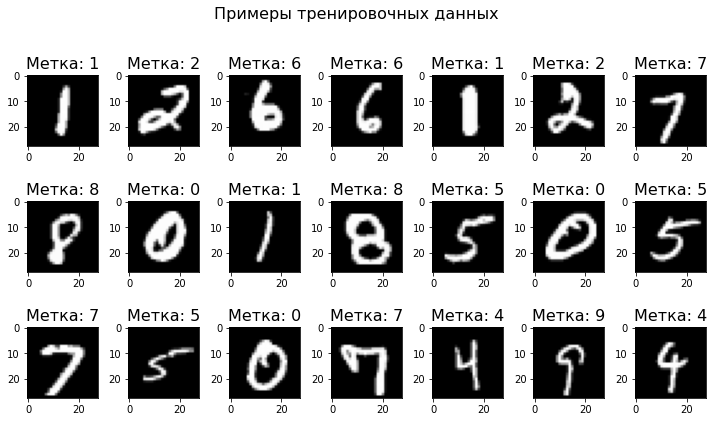

In [4]:
import random

plt.figure(figsize=(10, 6))
plt.suptitle('Примеры тренировочных данных\n', fontsize=16)

for i in range(21):
    plt.subplot(3, 7, i + 1)
    idx = random.randint(0, len(train_img) - 1)
    plt.imshow(train_img[idx], cmap='gray')
    plt.title(f'Метка: {train_labels[idx]}', fontsize=16)

plt.tight_layout()
plt.show()

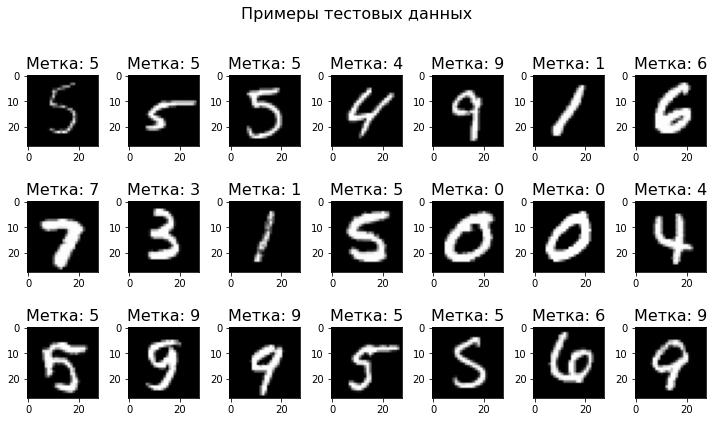

In [5]:
plt.figure(figsize=(10, 6))
plt.suptitle('Примеры тестовых данных\n', fontsize=16)

for i in range(21):
    plt.subplot(3, 7, i + 1)
    idx = random.randint(0, len(test_img) - 1)
    plt.imshow(test_img[idx], cmap='gray')
    plt.title(f'Метка: {test_labels[idx]}', fontsize=16)

plt.tight_layout()
plt.show()

## Функции активации

### 1. На скрытом слое: функция ReLU и ее производная

In [6]:
def ReLU(x):
    return np.maximum(0, x)

def d_ReLU(x):
    return (x > 0).astype(float)

### 2. На выходном слое: softmax

In [7]:
def softmax(u):
    exp = np.exp(u - np.max(u, axis = 1, keepdims = True))
    return exp / np.sum(exp, axis=1, keepdims=True)

### Функция ошибки: кросс-энтропия

In [8]:
def cross_entropy(y, u):
    return np.mean(-np.sum(y * np.log(u), axis = 1))

### Класс нейронной сети

In [9]:
class neuralNetwork:
    def __init__(self, num_input_n, num_hidden_n, num_output_n, lr):
        self.num_input_neuron = num_input_n
        self.num_hidden_neuron = num_hidden_n
        self.num_output_neuron = num_output_n
        self.learning_rate = lr
        
        scale = np.sqrt(2.0 / self.num_input_neuron)
        # Инициализация весов. Вес от входного к скрытому.
        self.W1 = np.random.randn(self.num_input_neuron, self.num_hidden_neuron) * scale
        # Инициализация весов. Вес от скрытого к выходному.
        self.W2 = np.random.randn(self.num_hidden_neuron, self.num_output_neuron) * scale

        # Смещения
        self.b1 = np.zeros((1, self.num_hidden_neuron)) # Для скрытого слоя
        self.b2 = np.zeros((1, self.num_output_neuron)) # Для выходного слоя
        
    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1  # Линейная часть скрытого слоя, Z1 - взвешенная сумма
        self.A1 = ReLU(self.Z1)  
        
        self.Z2 = np.dot(self.A1, self.W2) + self.b2  # Линейная часть выходного слоя, Z2 - взвешенная сумма
        self.A2 = softmax(self.Z2)
        return self.A2
    
    def backpropagation(self, x, y):
    
        # Ошибки на выходном и скрытом слоях
        err_2 = (self.forward(x) - y) / x.shape[0]
        err_1 = np.dot(err_2, self.W2.T) * d_ReLU(self.Z1)

        # Вычисление градиентов
        d_W2 = np.dot(self.A1.T, err_2)
        d_W1 = np.dot(x.T, err_1)

        d_b2 = np.sum(err_2, axis = 0, keepdims = True)
        d_b1 = np.sum(err_1, axis = 0, keepdims = True)

        # Обновление весов
        self.W1 -= self.learning_rate * d_W1
        self.W2 -= self.learning_rate * d_W2
        
        self.b1 -= self.learning_rate * d_b1
        self.b2 -= self.learning_rate * d_b2
        
    def shuffle_data(self, x, y):
        idx_arr = np.random.permutation(x.shape[0])
        return x[idx_arr], y[idx_arr]
    
    def train_one_epoch(self, x_train, y_train, batch_size):
        x_shuffled, y_shuffled = self.shuffle_data(x_train, y_train)
    
        for i in range(0, len(x_train), batch_size):
            x_batch = x_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]
        
            # Прямой проход и получение предсказаний (внутри backpropagation)
            # Обратный проход и обновление весов
            self.backpropagation(x_batch, y_batch)
    
        # Вычисляем метрики после эпохи на всех данных
        predictions = self.forward(x_train)

        # Accuracy: сравниваем предсказанные классы с истинными
        accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_train, axis=1))
    
        # Cross-Entropy Loss
        loss = cross_entropy(y_train, predictions)
    
        return accuracy, loss
    
    def train(self, x_train, y_train, epochs, batch_size):

        print("Начало обучения:")
    
        total_start_time = time.time()
    
        for epoch in range(epochs):
            epoch_start_time = time.time()
        
            # Одна эпоха обучения
            accuracy, loss = self.train_one_epoch(x_train, y_train, batch_size)
        
            epoch_duration = time.time() - epoch_start_time
        
            print(f"Эпоха: {epoch + 1}/{epochs}, "
                  f"Время: {epoch_duration:.3f}s, "
                  f"Точность: {accuracy:.5f}, "
                  f"Ошибка: {loss:.5f}")
    
        total_duration = time.time() - total_start_time
        print(f"Общее время обучения: {total_duration:.3f} сек")
        print('Обучение завершено!')
        
    def test(self, x_test, y_test):
        print("Начало тестирования:")
    
        test_start_time = time.time()
    
        # Прямой проход на тестовых данных
        predictions = self.forward(x_test)
    
        # Вычисление метрик
        value_cross_entropy = cross_entropy(y_test, predictions)
        value_accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
    
        duration_time = time.time() - test_start_time
    
        print(f"Время тестирования: {duration_time:.3f} сек")
        print(f"Ошибка: {value_cross_entropy:.6f}")
        print(f"Точность: {value_accuracy:.6f}")
    
        return value_cross_entropy, value_accuracy    
    
    def predict(self, x):
        return self.forward(x)
        

### Начальные параметры

In [10]:
input_size = 28 * 28  
hidden_size = 300  
output_size = 10  
learning_rate = 0.1
epochs = 20
batch_size = 32

In [11]:
train_img = train_img.reshape(-1, input_size)
test_img = test_img.reshape(-1, input_size)

train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

### Обучение модели

In [12]:
nn = neuralNetwork(input_size, hidden_size, output_size, learning_rate)
nn.train(train_img, train_labels, epochs, batch_size)

Начало обучения:
Эпоха: 1/20, Время: 6.071s, Точность: 0.95445, Ошибка: 0.16179
Эпоха: 2/20, Время: 6.147s, Точность: 0.97112, Ошибка: 0.10262
Эпоха: 3/20, Время: 6.153s, Точность: 0.97810, Ошибка: 0.07741
Эпоха: 4/20, Время: 6.255s, Точность: 0.98270, Ошибка: 0.06304
Эпоха: 5/20, Время: 6.378s, Точность: 0.98645, Ошибка: 0.04841
Эпоха: 6/20, Время: 5.933s, Точность: 0.99042, Ошибка: 0.03811
Эпоха: 7/20, Время: 5.862s, Точность: 0.99123, Ошибка: 0.03375
Эпоха: 8/20, Время: 5.869s, Точность: 0.99375, Ошибка: 0.02754
Эпоха: 9/20, Время: 5.939s, Точность: 0.99468, Ошибка: 0.02331
Эпоха: 10/20, Время: 5.883s, Точность: 0.99630, Ошибка: 0.01951
Эпоха: 11/20, Время: 5.834s, Точность: 0.99722, Ошибка: 0.01617
Эпоха: 12/20, Время: 5.865s, Точность: 0.99760, Ошибка: 0.01422
Эпоха: 13/20, Время: 5.873s, Точность: 0.99778, Ошибка: 0.01326
Эпоха: 14/20, Время: 5.882s, Точность: 0.99865, Ошибка: 0.01029
Эпоха: 15/20, Время: 5.846s, Точность: 0.99913, Ошибка: 0.00888
Эпоха: 16/20, Время: 5.876s, Точ

### Тестирование модели

In [13]:
nn.test(test_img, test_labels)

Начало тестирования:
Время тестирования: 0.152 сек
Ошибка: 0.064148
Точность: 0.982000


(0.06414752462553891, 0.982)